<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [5]:
data_dir = "Combined_train_validate"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.1,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

### two validation subsets, one is actually the sample subset to be used to tune the parameters
validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.1,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)


testOut_dataset = image_dataset_from_directory('testplantdoc',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
testIn_dataset = image_dataset_from_directory('plantville_test',
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.20,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 33391 files belonging to 13 classes.
Using 30052 files for training.
Found 33391 files belonging to 13 classes.
Using 3339 files for validation.
Found 120 files belonging to 13 classes.
Found 4026 files belonging to 13 classes.
Using 805 files for validation.


In [6]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper__bell___Bacterial_spot
5.  Pepper__bell___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


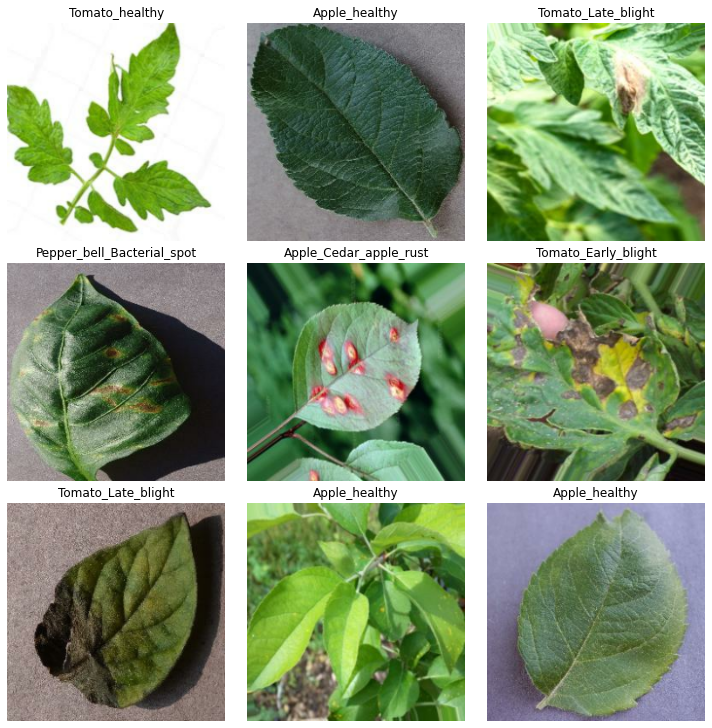

In [7]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

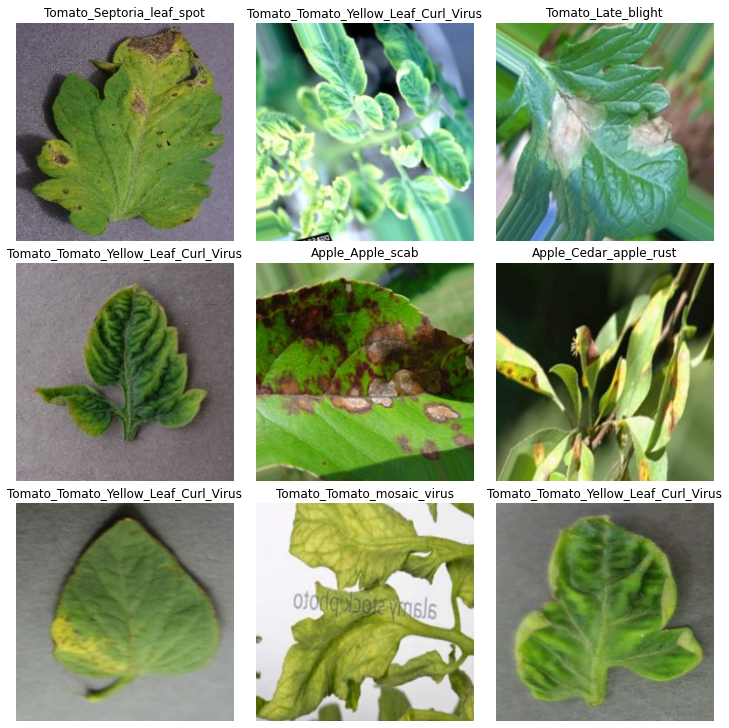

In [8]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 84
Number of test batches: 21


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testOut_datase = testOut_dataset.prefetch(buffer_size=AUTOTUNE)
testIn_datase = testIn_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
def plot_metrics(history):
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
  metrics = ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20,10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [13]:
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


9406464/9406464 [==============================] - 0s 0us/step


In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [18]:
base_model.trainable = False

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [21]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [23]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10

In [28]:
len(train_dataset)

940

In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
940/940 [==============================] - 95s 96ms/step - loss: 1.8955 - tp: 4896.0000 - fp: 909.0000 - tn: 359715.0000 - fn: 25156.0000 - accuracy: 0.4013 - precision: 0.8434 - recall: 0.1629 - auc: 0.8165 - val_loss: 1.3371 - val_tp: 798.0000 - val_fp: 75.0000 - val_tn: 31929.0000 - val_fn: 1869.0000 - val_accuracy: 0.5827 - val_precision: 0.9141 - val_recall: 0.2992 - val_auc: 0.9293
Epoch 2/10
940/940 [==============================] - 89s 94ms/step - loss: 1.2529 - tp: 11305.0000 - fp: 1641.0000 - tn: 358983.0000 - fn: 18747.0000 - accuracy: 0.6022 - precision: 0.8732 - recall: 0.3762 - auc: 0.9330 - val_loss: 1.0514 - val_tp: 1222.0000 - val_fp: 119.0000 - val_tn: 31885.0000 - val_fn: 1445.0000 - val_accuracy: 0.6723 - val_precision: 0.9113 - val_recall: 0.4582 - val_auc: 0.9583
Epoch 3/10
940/940 [==============================] - 92s 97ms/step - loss: 1.0464 - tp: 14362.0000 - fp: 2010.0000 - tn: 358614.0000 - fn: 15690.0000 - accuracy: 0.6652 - precision: 0.8772 - 

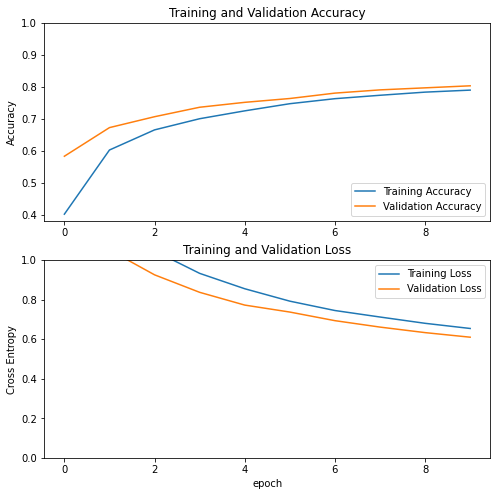

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

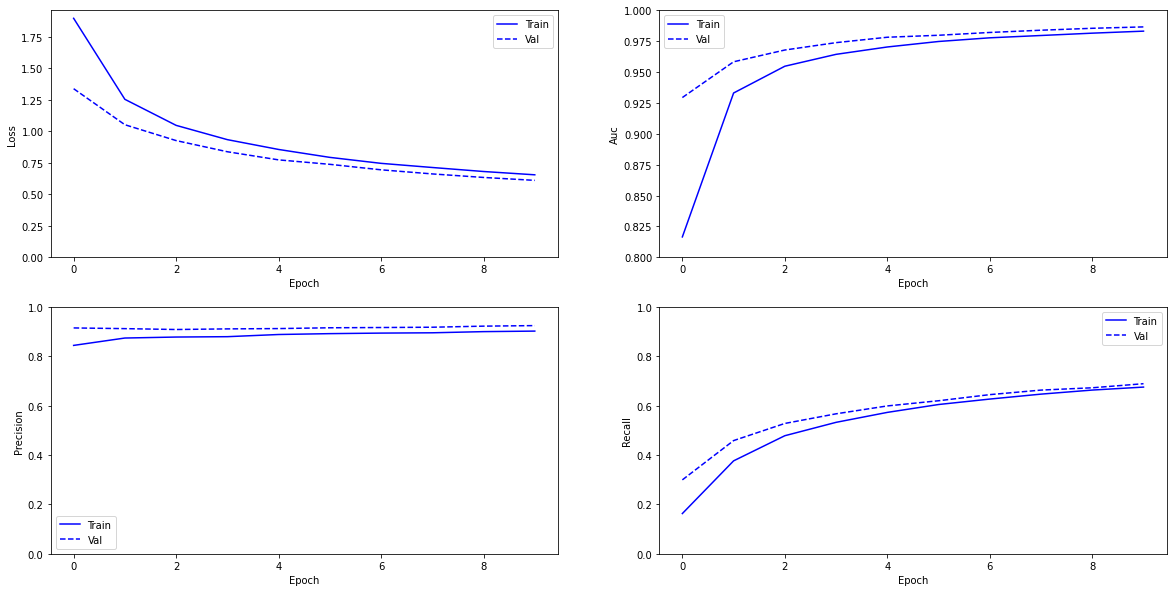

In [31]:
plot_metrics(history)

Start fine tuning phase

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [34]:
# Learning rate goes dowb by a factor of 10
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [36]:
len(model.trainable_variables)

56

In [37]:

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
940/940 [==============================] - 136s 138ms/step - loss: 0.4956 - tp: 25063.0000 - fp: 2886.0000 - tn: 389742.0000 - fn: 7656.0000 - accuracy: 0.8291 - precision: 0.8967 - recall: 0.7660 - auc: 0.9888 - val_loss: 0.3517 - val_tp: 2237.0000 - val_fp: 170.0000 - val_tn: 31834.0000 - val_fn: 430.0000 - val_accuracy: 0.8841 - val_precision: 0.9294 - val_recall: 0.8388 - val_auc: 0.9950
Epoch 11/15
940/940 [==============================] - 129s 137ms/step - loss: 0.3007 - tp: 26109.0000 - fp: 1821.0000 - tn: 358803.0000 - fn: 3943.0000 - accuracy: 0.9028 - precision: 0.9348 - recall: 0.8688 - auc: 0.9958 - val_loss: 0.2464 - val_tp: 2360.0000 - val_fp: 135.0000 - val_tn: 31869.0000 - val_fn: 307.0000 - val_accuracy: 0.9156 - val_precision: 0.9459 - val_recall: 0.8849 - val_auc: 0.9977
Epoch 12/15
940/940 [==============================] - 129s 137ms/step - loss: 0.1979 - tp: 27585.0000 - fp: 1270.0000 - tn: 359354.0000 - fn: 2467.0000 - accuracy: 0.9379 - precision: 0

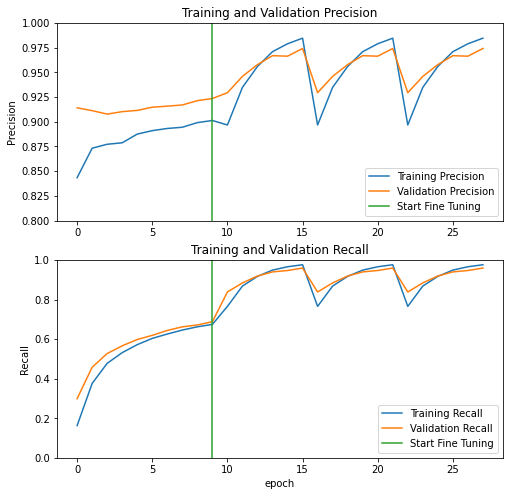

In [41]:
precision += history_fine.history['precision']
val_prec += history_fine.history['val_precision']

recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.ylabel('Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.show()

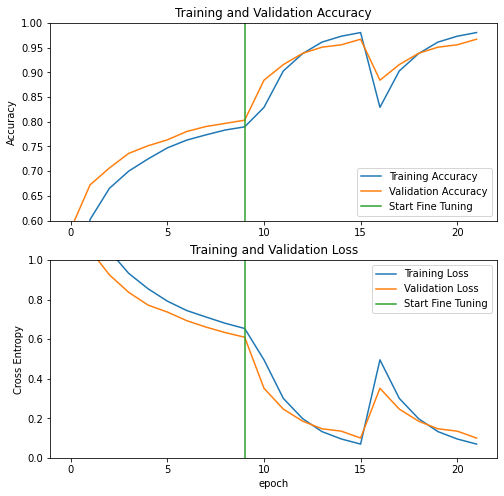

In [42]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

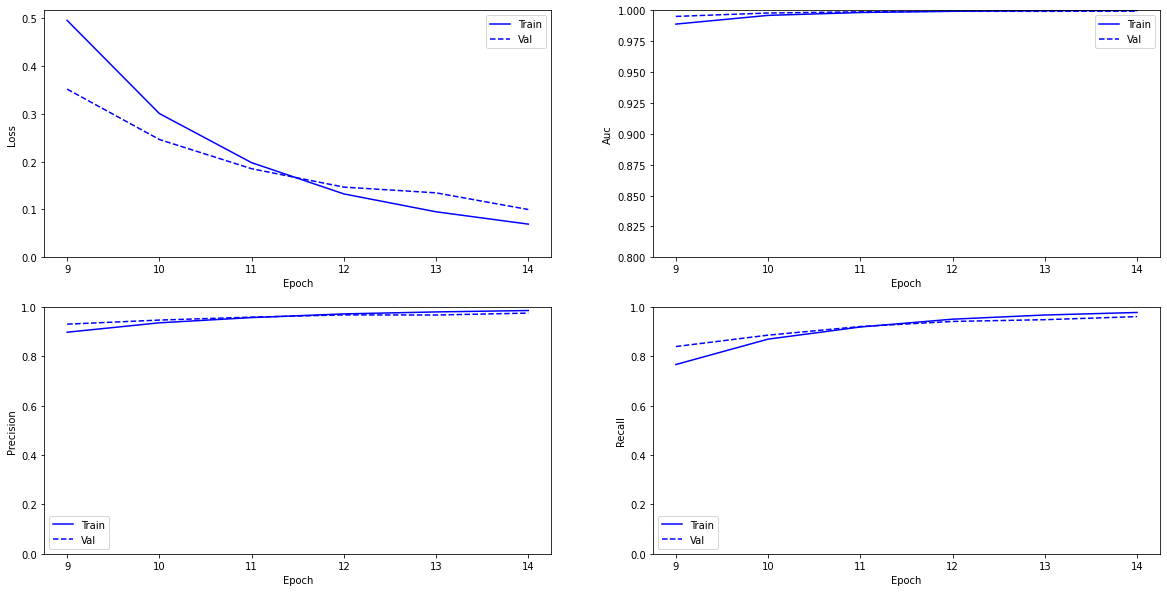

In [43]:
plot_metrics(history_fine)

In [44]:
resultOut = model.evaluate(testOut_dataset)

4/4 [==============================] - 2s 199ms/step - loss: 7.7100 - tp: 11.0000 - fp: 99.0000 - tn: 1341.0000 - fn: 109.0000 - accuracy: 0.0917 - precision: 0.1000 - recall: 0.0917 - auc: 0.5584


In [45]:
resultIn = model.evaluate(testIn_dataset)

26/26 [==============================] - 3s 97ms/step - loss: 0.0843 - tp: 783.0000 - fp: 19.0000 - tn: 9641.0000 - fn: 22.0000 - accuracy: 0.9727 - precision: 0.9763 - recall: 0.9727 - auc: 0.9985


In [46]:
print(len(testIn_dataset))

26


In [47]:
print(len(testOut_dataset))

4


In [48]:
print(len(validation_dataset))

84


In [49]:
print(len(train_dataset))

940


In [50]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(resultIn)):
    print("{} : {}".format(metrics[i],round(resultIn[i], 3)))

loss : 0.084
tp : 783.0
fp : 19.0
tn : 9641.0
fn : 22.0
accuracy : 0.973
precision : 0.976
recall : 0.973
auc : 0.998


In [52]:
metrics = ["loss", "tp", "fp", "tn", "fn", "accuracy", "precision", "recall", "auc"]
for i in range(len(resultOut)):
    print("{} : {}".format(metrics[i],round(resultOut[i], 3)))

loss : 7.71
tp : 11.0
fp : 99.0
tn : 1341.0
fn : 109.0
accuracy : 0.092
precision : 0.1
recall : 0.092
auc : 0.558


Predictions:
 [10, 5, 12, 12, 5, 10, 8, 10, 10, 10, 10, 4, 9, 0, 9, 12, 8, 7, 2, 5, 5, 10, 10, 8, 10, 2, 2, 10, 10, 10, 12, 6]
Labels:
 [10, 5, 12, 12, 5, 10, 8, 10, 10, 10, 10, 4, 9, 0, 9, 12, 8, 7, 2, 5, 5, 10, 10, 8, 10, 2, 2, 10, 10, 10, 12, 6]


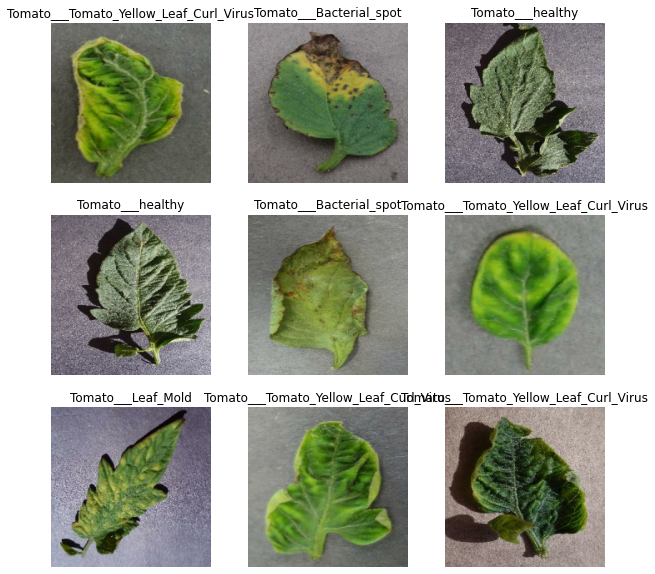

In [53]:
#Retrieve a batch of images from the test set indoors
image_batch, label_batch = testIn_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [54]:
models.save_model(model, "./HPMobileNetAdam_Combined")

INFO:tensorflow:Assets written to: ./HPMobileNetAdam_Combined/assets


INFO:tensorflow:Assets written to: ./HPMobileNetAdam_Combined/assets
